In [244]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tqdm
import sys
import time
import datetime
import scipy.stats
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.calibration import calibration_curve

from Py_Files import metric_inventory
from Py_Files import aws_rds
from Py_Files import credentials
from Py_Files import data_exploration


print(sys.executable)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/joeybortfeld/opt/anaconda3/envs/investment_analysis/bin/python


In [245]:
data = pd.read_csv('/Users/joeybortfeld/Downloads/modeling_dataset_with_bankruptcy_labels.csv')
data['constant'] = 1
print(data.shape)
print(data['fsym_id'].nunique())
print(data['fiscal_end_date'].min())
print(data['fiscal_end_date'].max())

print(data['default_1'].value_counts())



/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/1434458862.py:1: DtypeWarning: Columns (155) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/joeybortfeld/Downloads/modeling_dataset_with_bankruptcy_labels.csv')


(902682, 163)
15396
1990-01-31
2024-12-31
default_1
 0    898929
-1      2350
 1      1403
Name: count, dtype: int64


In [246]:
def calculate_percentile_bins(data, column, num_bins=100):
    """
    Calculate boundaries for dividing the data into equal percentile bins.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the data.
        column (str): The column name to calculate percentiles for.
        num_bins (int): Number of percentile bins (default: 100).
    
    Returns:
        np.ndarray: Array of boundaries dividing the column into bins.
    """
    percentiles = np.linspace(0, 1, num_bins + 1)
    boundaries = data[column].quantile(percentiles).values
    return boundaries



def assign_to_bins(data, column, boundaries):
    """
    Assign values in the column to percentile bins based on given boundaries.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing the new data.
        column (str): The column name to classify.
        boundaries (np.ndarray): Array of bin boundaries.
    
    Returns:
        pd.Series: Bin indices for each value in the column.
    """
    bins = np.digitize(data[column], bins=boundaries, right=True) - 1
    num_bins = len(boundaries) - 1
    assert num_bins == 1000, 'number of bins is not 1000'

    bins = bins/10 # rescale such that percentiles are 0-100
    bins = bins + 0.1
    return bins

def apply_model(data, coeff_dict, cutpoints_dict):

    df = data.copy()
    
    # apply percentile transformations
    for x, boundaries in cutpoints_dict.items():
        df[f'{x}_pct'] = assign_to_bins(df, column=x, boundaries=boundaries)


    # apply model to calculate pd1, pd2, pd3, pd4, pd5
    for y_var in ['default_1', 'default_2', 'default_3', 'default_4', 'default_5']:

        output_var = f'pd_{y_var[-1]}'
        df[output_var] = 0
        for var, coeff in coeff_dict[y_var].items():
            df[output_var] += df[var] * coeff

        df[output_var] = np.exp(df[output_var]) / (1 + np.exp(df[output_var]))

    # calculate cumulative pd
    df['cumulative_pd_1'] = df['pd_1']
    df['cumulative_pd_2'] = df['cumulative_pd_1'] + (1 - df['cumulative_pd_1']) * df['pd_2']
    df['cumulative_pd_3'] = df['cumulative_pd_2'] + (1 - df['cumulative_pd_2']) * df['pd_3']
    df['cumulative_pd_4'] = df['cumulative_pd_3'] + (1 - df['cumulative_pd_3']) * df['pd_4']
    df['cumulative_pd_5'] = df['cumulative_pd_4'] + (1 - df['cumulative_pd_4']) * df['pd_5']

    return df

def build_calibration_curve(data, n_bins=500):

    collection = []
    for t in [1,2,3,4,5]:

        y_var = f'default_{t}'
        pd_var = f'pd_{t}'

        temp = data[[y_var, pd_var]].copy()
        temp = temp[temp[y_var] != -1]

        prop_true_uniform, prop_pred_uniform = calibration_curve(temp[y_var], temp[pd_var], strategy='uniform', n_bins=n_bins)
        df1 = pd.DataFrame({'prop_true': prop_true_uniform, 'prop_pred': prop_pred_uniform})
        df1['t'] = t
        df1['bin_type'] = 'uniform'
        collection.append(df1)

        prop_true_quantile, prop_pred_quantile = calibration_curve(temp[y_var], temp[pd_var], strategy='quantile', n_bins=n_bins)
        df2 = pd.DataFrame({'prop_true': prop_true_quantile, 'prop_pred': prop_pred_quantile})
        df2['t'] = t
        df2['bin_type'] = 'quantile'
        collection.append(df2)

    collection = pd.concat(collection, axis=0)
    collection['n_bins'] = n_bins

    # calculate correlation between prop_true and prop_pred
    collection1 = []
    for t in [1,2,3,4,5]:
        for bin_type in ['uniform', 'quantile']:
            
            temp1 = collection[(collection['t'] == t)] 
            temp1 = temp1[(temp1['bin_type'] == bin_type)]

            corr_pearson = temp1[['prop_true', 'prop_pred']].corr(method='pearson').iloc[0][1]
            corr_spearman = temp1[['prop_true', 'prop_pred']].corr(method='spearman').iloc[0][1]
            collection1.append([t, bin_type, corr_pearson, corr_spearman])

    collection1 = pd.DataFrame(collection1, columns=['t', 'bin_type', 'corr_pearson', 'corr_spearman'])
    collection = collection.merge(collection1, on=['t', 'bin_type'], how='left')
            

    return collection


def confusion_matrix_metrics(data):

    df = data[['default_1', 'default_2', 'default_3', 'default_4', 'default_5',
               'pd_1', 'pd_2', 'pd_3', 'pd_4', 'pd_5',
               'cumulative_pd_1', 'cumulative_pd_2', 'cumulative_pd_3', 'cumulative_pd_4', 'cumulative_pd_5']].copy()
    
    # mark if defaulted at any point up to horizon i 
    for i in [1,2,3,4,5]:
        df[f'cumulative_default_{i}'] = 0
        
        for j in range(1,i+1):
            mask = df[f'default_{j}'] == 1
            df.loc[mask, f'cumulative_default_{i}'] = 1

    # generate confusion matrix metrics for pd 1-5
    collection = []
    for t in [1,2,3,4,5]:

        y_var = f'default_{t}'
        pd_var = f'pd_{t}'

        temp = df[[y_var, pd_var]].copy()
        temp = temp[temp[y_var] != -1]        

        for thresh in tqdm.tqdm(np.linspace(0,.10, 100)):

            temp['y_pred_class'] = 0
            mask = temp[pd_var] >= thresh
            temp.loc[mask, 'y_pred_class'] = 1

            true_pos = ((temp[y_var] == 1) & (temp['y_pred_class'] == 1)).sum()
            false_pos = ((temp[y_var] == 0) & (temp['y_pred_class'] == 1)).sum()
            true_neg = ((temp[y_var] == 0) & (temp['y_pred_class'] == 0)).sum()
            false_neg = ((temp[y_var] == 1) & (temp['y_pred_class'] == 0)).sum()

            sensitivity = true_pos / (true_pos + false_neg)
            specificity = true_neg / (true_neg + false_pos)
            precision = true_pos / (true_pos + false_pos)
            negative_predictive_value = true_neg / (true_neg + false_neg)

            f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

            tpr = sensitivity
            fpr = 1 - specificity

            collection.append([str(t),thresh, sensitivity, specificity, precision, negative_predictive_value, f1, tpr, fpr ])

    # generate confusion matrix metrics for cumulative default 1-5
    for t in [1,2,3,4,5]:

        y_var = f'cumulative_default_{t}'
        pd_var = f'cumulative_pd_{t}'

        temp = df[[y_var, pd_var]].copy()
        temp = temp[temp[y_var] != -1]        

        for thresh in tqdm.tqdm(np.linspace(0,.10, 100)):

            temp['y_pred_class'] = 0
            mask = temp[pd_var] >= thresh
            temp.loc[mask, 'y_pred_class'] = 1

            true_pos = ((temp[y_var] == 1) & (temp['y_pred_class'] == 1)).sum()
            false_pos = ((temp[y_var] == 0) & (temp['y_pred_class'] == 1)).sum()
            true_neg = ((temp[y_var] == 0) & (temp['y_pred_class'] == 0)).sum()
            false_neg = ((temp[y_var] == 1) & (temp['y_pred_class'] == 0)).sum()

            sensitivity = true_pos / (true_pos + false_neg)
            specificity = true_neg / (true_neg + false_pos)
            precision = true_pos / (true_pos + false_pos)
            negative_predictive_value = true_neg / (true_neg + false_neg)

            f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

            tpr = sensitivity
            fpr = 1 - specificity

            collection.append([f'c{t}',thresh, sensitivity, specificity, precision, negative_predictive_value, f1, tpr, fpr ])        
    

    collection = pd.DataFrame(collection, columns=['t', 'thresh', 'sensitivity', 'specificity', 'precision', 'negative_predictive_value', 'f1', 'tpr', 'fpr'])
    return collection

def calculate_variable_correlations(data, x_vars):

    x_vars_trim = x_vars.copy()
    if 'constant' in x_vars_trim:
        x_vars_trim.remove('constant')
        
    # calculate pearson correlations
    df1 = data[x_vars_trim].corr(method='pearson')
    df1 = df1.reset_index(drop=False)
    df1['method'] = 'pearson'

    # calculate spearman correlations
    df2 = data[x_vars_trim].corr(method='spearman')
    df2 = df2.reset_index(drop=False)   
    df2['method'] = 'spearman'

    df = pd.concat([df1, df2], axis=0)
    df = df.rename(columns={'index': 'x'})

    return df

    

In [ ]:
model_list = [

{'model_number': 0, 'model_name': 'baseline model',
 'x1_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x2_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x3_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x4_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x5_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('total_debt_to_ebitda', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'add_sector_dummies': False,
 'sector_dummies_var': 'factset_econ_sector'
 },

{'model_number': 1, 'model_name': 'baseline model',
 'x1_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x2_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x3_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x4_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'x5_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('constant', 'level')],
 'add_sector_dummies': False,
 'sector_dummies_var': 'factset_econ_sector'
 },

 {'model_number': 2, 'model_name': 'baseline model',
 'x1_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
 'x2_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
 'x3_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
 'x4_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
 'x5_specs': [('total_equity_to_assets', 'pct'), ('net_income_to_sales', 'pct'), ('ebitda_to_net_debt', 'pct'), ('cash_to_total_debt', 'pct'), ('ebitda_vol', 'pct'), ('constant', 'level')],
 'add_sector_dummies': False,
 'sector_dummies_var': 'factset_econ_sector'
 },


]

In [306]:
########################################################
# define predictor variables
incl_sector_dummies = False
sector_dummies_var = 'factset_econ_sector'

model_meta = [0, 'baseline model']
x_specs =[('total_equity_to_assets', 'pct'), 
         ('net_income_to_sales', 'pct'), 
         ('total_debt_to_ebitda', 'pct'), 
         ('cash_to_total_debt', 'pct'), 
         ('constant', 'level')]


model_meta = [1, 'baseline model']
x_specs =[('total_equity_to_assets', 'pct'), 
         ('net_income_to_sales', 'pct'), 
         ('ebitda_to_net_debt', 'pct'), 
         ('cash_to_total_debt', 'pct'), 
         ('constant', 'level')]

model_num = model_meta[0]
model_name = model_meta[1]

x_base_vars = [x[0] for x in x_specs]
x_vars = [x[0] if x[1] == 'level' else f'{x[0]}_pct'for x in x_specs]
x_to_pct = [x[0] for x in x_specs if x[1] == 'pct']
        
print('x_vars:', x_vars)
print('vars to apply percentiles to:', x_to_pct)

########################################################
# build training dataset
df_train = data[['fsym_id', 'fiscal_end_date', 'factset_econ_sector'] + x_base_vars + ['default_1', 'default_2', 'default_3', 'default_4', 'default_5']].copy()

if incl_sector_dummies:
    
    # construct sector dummies
    sector_dummies = pd.get_dummies(df_train[sector_dummies_var], prefix='sector', dtype=float, drop_first=True)
    df_train = pd.concat([df_train, sector_dummies], axis=1)
    x_vars = x_vars + sector_dummies.columns.tolist()
    print('--sector holdout:', [x for x in df_train[sector_dummies_var].unique() if not f'sector_{x}' in sector_dummies.columns])
    print('--including sector dummies:', x_vars)

# drop rows with incomplete x-variables
mask = df_train[x_base_vars].isna().any(axis=1)
df_train = df_train[~mask]

# apply percentile transfomations to x-variables
if len(x_to_pct) > 0:

    cutpoints_dict = {}
    for x in x_to_pct:
        print(f'--calculating cutpoints for {x}')
        this_boundaries = calculate_percentile_bins(df_train, column=x, num_bins=1000)
        cutpoints_dict[x] = this_boundaries
        df_train[f'{x}_pct'] = assign_to_bins(df_train, column=x, boundaries=this_boundaries)

# calculate variable correlations
df_correlation = calculate_variable_correlations(df_train, x_vars)
df_correlation.to_csv(f'/Users/joeybortfeld/Downloads/model_variable_correlations_{model_num}.csv', index=False)


########################################################
# iterate over default horizons
all_stats = []
intra_sector_auroc = []
sector_means =[]
cross_sector_rank_corr = []
coeff_dict = {}

for y_var in ['default_1', 'default_2', 'default_3', 'default_4', 'default_5']:

    coeff_dict[y_var] = {}

    # subset the training data to ignore default=-1
    dff = df_train[df_train[y_var] != -1].copy()

    # estimation dataset statistics
    nobs = dff.shape[0]
    n_fsym_id = dff['fsym_id'].nunique()
    n_default = dff[y_var].sum()
    n_fsym_id_default = dff[dff[y_var]==1]['fsym_id'].nunique()
    
    # regression
    X = dff[x_vars]
    y = dff[y_var].values
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    
    # collect estimated regression parameters and performance
    coefs = result.params
    tstats = result.tvalues
    pvals = result.pvalues

    # calculate AUROC
    y_pred = result.predict(X)
    dff['y_pred'] = y_pred
    auroc = roc_auc_score(np.array(y), np.array(y_pred))
    
    # save in-sample statistics as table
    stats = pd.DataFrame({'x': x_vars, 'coef': coefs, 'tstat': tstats, 'pval': pvals})
    stats['auroc'] = auroc
    stats['y'] = y_var
    stats['nobs'] = nobs
    stats['n_fsym_id'] = n_fsym_id
    stats['n_default'] = n_default
    stats['n_fsym_default'] = n_fsym_id_default

    # calculate pseudo-weights
    X_stds = X.std()
    stats['x_sd'] = stats['x'].map(lambda x: X_stds[x])
    stats['weight'] = abs(stats['coef']) * stats['x_sd']
    stats['weight'] = stats['weight'] / stats['weight'].sum()

    all_stats.append(stats)

    # collect regression coefficients for later calculations and save into dictionary
    for i, var in enumerate(x_vars):
        coeff_dict[y_var][var] = coefs[i]

    # calculate in-sample intra-sector auroc
    sector_list = ['All'] + list(dff['factset_econ_sector'].unique()) 
    sector_auroc_list = []
    for this_sector in sector_list:

        if this_sector == 'All':
            dff_sector = dff.copy()
        else:
            dff_sector = dff[dff['factset_econ_sector'] == this_sector].copy()

        if dff_sector[y_var].sum() > 0:
            auroc = roc_auc_score(dff_sector[y_var], dff_sector['y_pred'])
            sector_auroc_list.append([this_sector, auroc])
    
    sector_auroc = pd.DataFrame(sector_auroc_list, columns=['sector', 'auroc'])
    sector_auroc = sector_auroc.rename(columns={'auroc': y_var + '_auroc'})
    sector_auroc = sector_auroc.set_index('sector')
    intra_sector_auroc.append(sector_auroc)

    # calculate ecological inter-sector rank correlation
    df_sector = dff.copy()
    df_sector= df_sector.groupby('factset_econ_sector', as_index=False)[[y_var, 'y_pred']].mean()

    sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]
    cross_sector_rank_corr.append([y_var, sector_rank_corr])

    df_sector = df_sector.rename(columns={y_var: 'y_actual'})
    df_sector['t'] = y_var[-1]   
    sector_means.append(df_sector)


# output 1 - regression statistics
all_stats = pd.concat(all_stats)
all_stats['timestamp'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
all_stats['model_number'] = model_meta[0]
all_stats['model_name'] = model_meta[1]
all_stats = all_stats[['model_number', 'model_name', 'timestamp', 'y', 'x', 'coef', 'tstat', 'pval', 'weight', 'auroc', 'nobs', 'n_fsym_id', 'n_default', 'n_fsym_default']]
all_stats = all_stats.reset_index(drop=True)
all_stats.to_csv(f'/Users/joeybortfeld/Downloads/model_regression_summary_{model_num}.csv', index=False)


# output 2 - AUROC default/non-default discrimination by sector
intra_sector_auroc = pd.concat(intra_sector_auroc, axis=1) 
intra_sector_auroc['average'] = intra_sector_auroc.mean(axis=1)
intra_sector_auroc = intra_sector_auroc.reset_index(drop=False)
intra_sector_auroc = intra_sector_auroc.sort_values(by='average', ascending=False)
intra_sector_auroc.to_csv(f'/Users/joeybortfeld/Downloads/model_intra_sector_auroc_{model_num}.csv', index=False)

sector_means = pd.concat(sector_means, axis=0)
sector_means.to_csv(f'/Users/joeybortfeld/Downloads/model_sector_means_{model_num}.csv', index=False)

cross_sector_rank_corr = pd.DataFrame(cross_sector_rank_corr, columns=['y', 'spearman'])
cross_sector_rank_corr.to_csv(f'/Users/joeybortfeld/Downloads/model_cross_sector_rank_corr_{model_num}.csv', index=False)

# output 3 - flag high PD but non defaulted firms

# apply model to full dataset (so that we can see scores all the way to default, recall we drop default=-1)


# apply model to full dataset (including cumulative pd calculations)
df = data.copy()
df = apply_model(df, coeff_dict, cutpoints_dict)

# build calibration curve
df_calibration_curve = build_calibration_curve(data=df, n_bins=500)
df_calibration_curve.to_csv(f'/Users/joeybortfeld/Downloads/model_calibration_curve_{model_num}.csv', index=False)

# build confusion matrix derivative metrics: including TPR, FPR, Precision, Recall, F1,
df_confusion_summary = confusion_matrix_metrics(df)
df_confusion_summary.to_csv(f'/Users/joeybortfeld/Downloads/model_confusion_summary_{model_num}.csv', index=False)


x_vars: ['total_equity_to_assets_pct', 'net_income_to_sales_pct', 'ebitda_to_net_debt_pct', 'cash_to_total_debt_pct', 'constant']
vars to apply percentiles to: ['total_equity_to_assets', 'net_income_to_sales', 'ebitda_to_net_debt', 'cash_to_total_debt']
--calculating cutpoints for total_equity_to_assets
--calculating cutpoints for net_income_to_sales
--calculating cutpoints for ebitda_to_net_debt
--calculating cutpoints for cash_to_total_debt
Optimization terminated successfully.
         Current function value: 0.011241
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]


Optimization terminated successfully.
         Current function value: 0.011875
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]


Optimization terminated successfully.
         Current function value: 0.011457
         Iterations 12


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]


Optimization terminated successfully.
         Current function value: 0.010786
         Iterations 11


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]


Optimization terminated successfully.
         Current function value: 0.010384
         Iterations 11


/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:119: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coeff_dict[y_var][var] = coefs[i]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/4133523682.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sector_rank_corr = df_sector[[y_var, 'y_pred']].corr(method='spearman').iloc[0][1]
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/285576944.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

In [303]:
def calculate_variable_correlations(data, x_vars):

    x_vars_trim = x_vars.copy()
    if 'constant' in x_vars_trim:
        x_vars_trim.remove('constant')
        
    # calculate pearson correlations
    df1 = data[x_vars_trim].corr(method='pearson')
    df1 = df1.reset_index(drop=False)
    df1['method'] = 'pearson'

    # calculate spearman correlations
    df2 = data[x_vars_trim].corr(method='spearman')
    df2 = df2.reset_index(drop=False)   
    df2['method'] = 'spearman'

    df = pd.concat([df1, df2], axis=0)
    df = df.rename(columns={'index': 'x'})

    return df


temp = calculate_variable_correlations(df, x_vars)
temp


,x,total_equity_to_assets_pct,net_income_to_sales_pct,total_debt_to_ebitda_pct,cash_to_total_debt_pct,method
0,total_equity_to_assets_pct,1.000000,0.334026,-0.243258,0.566160,pearson
1,net_income_to_sales_pct,0.334026,1.000000,0.163843,0.188828,pearson
2,total_debt_to_ebitda_pct,-0.243258,0.163843,1.000000,-0.250245,pearson
3,cash_to_total_debt_pct,0.566160,0.188828,-0.250245,1.000000,pearson
0,total_equity_to_assets_pct,1.000000,0.334815,-0.185470,0.574375,spearman
1,net_income_to_sales_pct,0.334815,1.000000,0.245511,0.197947,spearman
2,total_debt_to_ebitda_pct,-0.185470,0.245511,1.000000,-0.184589,spearman
3,cash_to_total_debt_pct,0.574375,0.197947,-0.184589,1.000000,spearman


In [250]:
fsym_list = ['DG71WP-R', 'DG885T-R', 'C5CPSB-R']
for fsym in fsym_list:
    df[df['fsym_id'] == fsym].to_csv(f'/Users/joeybortfeld/Downloads/model_output_{model_num}_{fsym}.csv', index=False)


In [268]:
temp = df[['default_1', 'default_2', 'default_3', 'default_4', 'default_5',
     
               'pd_1', 'pd_2', 'pd_3', 'pd_4', 'pd_5',
               'cumulative_pd_1', 'cumulative_pd_2', 'cumulative_pd_3', 'cumulative_pd_4', 'cumulative_pd_5']].copy()

# mark if defaulted at any point up to horizon i 
for i in [1,2,3,4,5]:
    temp[f'cumulative_default_{i}'] = 0
    
    for j in range(1,i+1):
        mask = temp[f'default_{j}'].isin([-1,1]) 
        temp.loc[mask, f'cumulative_default_{i}'] = 1

# calculate auroc for cumulative default
for i in [1,2,3,4,5]:
    temp2 = temp[temp[f'cumulative_pd_{i}'].notnull()]
    print(i, roc_auc_score(temp2[f'cumulative_default_{i}'], temp2[f'cumulative_pd_{i}']))

    temp2 = temp[temp[f'pd_{i}'].notnull()]
    temp2 = temp2[temp2[f'default_{i}'] != -1]
    print(i, roc_auc_score(temp2[f'default_{i}'], temp2[f'pd_{i}']))
    print()


1 0.8361783713844274
1 0.8875021503672049

2 0.8301677970356244
2 0.8177734955459225

3 0.8131261963834852
3 0.7484055370323189

4 0.7995097288645824
4 0.7266729939154858

5 0.7880626913079942
5 0.7071369963010077



In [282]:
for i in [1,2,3,4,5]:
    temp = df[df[f'default_{i}'] != -1]
    temp = temp[temp[f'pd_{i}'].notnull()]
    print(i, temp[f'default_{i}'].mean(), temp[f'pd_{i}'].mean())

1 0.0015583140441526014 0.0015111545577657017
2 0.0015651959164739372 0.0014903894711482942
3 0.0014852003627766226 0.001373084541168448
4 0.0013501616288528425 0.0012860657887223857
5 0.0012167883268769434 0.0012278753063993965


  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/2937234272.py:39: RuntimeWarning: invalid value encountered in scalar divide
  negative_predictive_value = true_neg / (true_neg + false_neg)
 38%|███▊      | 38/100 [00:00<00:00, 187.60it/s]/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/2937234272.py:41: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/2937234272.py:41: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/2937234272.py:41: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
/var/folders/yd/ftykl3xj33b10g8wq6w9ccmh0000gn/T/ipykernel_83915/2937234272.py:41: Ru

<Axes: xlabel='thresh'>

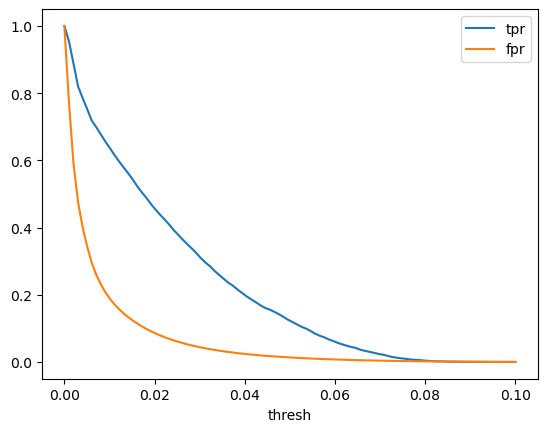

In [283]:


temp = confusion_matrix_metrics(df)
temp = temp[temp['t'] == 'c5']
temp.set_index('thresh')[['tpr', 'fpr']].plot()

In [256]:
temp.head(10)

,t,thresh,sensitivity,specificity,precision,negative_predictive_value,f1,TPR,FPR
0,1,0.000000,1.000000,0.000000,0.001558,NaN,0.003112,1.000000,1.000000
1,1,0.001010,0.855310,0.763410,0.005611,0.999704,0.011148,0.855310,0.236590
2,1,0.002020,0.811119,0.837161,0.007714,0.999648,0.015283,0.811119,0.162839
3,1,0.003030,0.774056,0.874958,0.009569,0.999597,0.018905,0.774056,0.125042
4,1,0.004040,0.724875,0.899743,0.011159,0.999523,0.021979,0.724875,0.100257
5,1,0.005051,0.682110,0.917589,0.012753,0.999460,0.025039,0.682110,0.082411
6,1,0.006061,0.643621,0.931105,0.014371,0.999403,0.028114,0.643621,0.068895
7,1,0.007071,0.603706,0.941619,0.015883,0.999344,0.030952,0.603706,0.058381
8,1,0.008081,0.572345,0.950219,0.017628,0.999298,0.034202,0.572345,0.049781
9,1,0.009091,0.528154,0.956982,0.018802,0.999231,0.036311,0.528154,0.043018


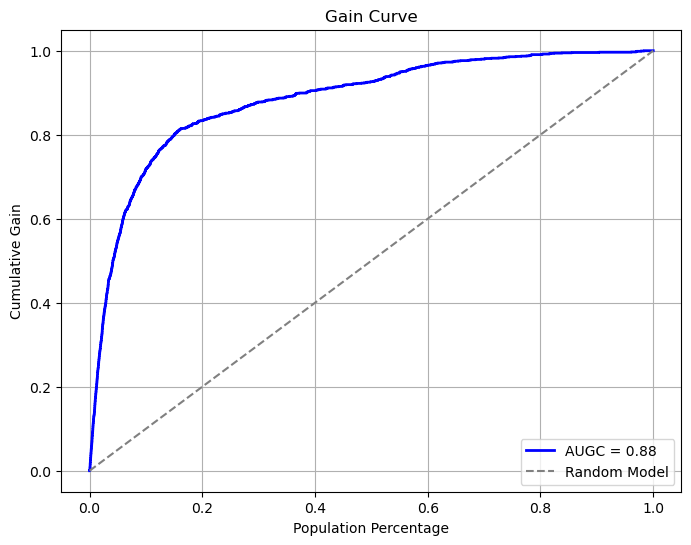

Area Under Gain Curve (AUGC): 0.88


In [226]:
import numpy as np
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# Example dataset
y_true = np.array([0, 1, 1, 0, 1, 0, 0, 1, 0, 1])  # True binary labels
y_pred_probs = np.array([0.05, 0.9, 0.8, 0.4, 0.7, 0.2, 0.3, 0.85, 0.1, 0.95])  # Predicted probabilities

temp = df.copy()
temp = temp[temp['default_1'] != -1]
temp = temp[temp['pd_1'].notnull()]
temp = temp.reset_index(drop=True)

y_true = temp['default_1']
y_pred_probs = temp['pd_1']

# Step 1: Sort by predicted probabilities
sorted_indices = np.argsort(y_pred_probs)[::-1]
sorted_y_true = y_true[sorted_indices]

# Step 2: Calculate cumulative gains
cumulative_gain = np.cumsum(sorted_y_true) / np.sum(sorted_y_true)

# Step 3: Population percentages
population_percentage = np.linspace(0, 1, len(cumulative_gain))

# Step 4: Calculate Area Under Gain Curve (AUGC)
gain_auc = auc(population_percentage, cumulative_gain)

# Step 5: Plot Gain Curve
plt.figure(figsize=(8, 6))
plt.plot(population_percentage, cumulative_gain, label=f'AUGC = {gain_auc:.2f}', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')  # Baseline for random performance
plt.xlabel('Population Percentage')
plt.ylabel('Cumulative Gain')
plt.title('Gain Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Output AUGC
print(f"Area Under Gain Curve (AUGC): {gain_auc:.2f}")


In [190]:
df_calibration_curve


,prop_true,prop_pred,t,bin_type,n_bins
0,0.000337,0.000280,1,uniform,500
1,0.001937,0.002868,1,uniform,500
2,0.003846,0.004907,1,uniform,500
3,0.005709,0.006930,1,uniform,500
4,0.008564,0.008929,1,uniform,500
...,...,...,...,...,...
478,0.005587,0.005323,5,quantile,500
479,0.005028,0.005549,5,quantile,500
480,0.006145,0.005848,5,quantile,500
481,0.002235,0.006351,5,quantile,500


In [193]:

import ast
temp = '''[("total_equity_to_assets", "pct"), ("net_income_to_sales", "pct"), ("total_debt_to_ebitda", "pct"), ("cash_to_total_debt", "pct"), ("constant", "level")]'''

# parse the string into a list of tuples
x_specs = ast.literal_eval(temp)


In [ ]:
from statsmodels.formula.api import mixedlm
from statsmodels.genmod.families import Binomial

endog = dff['default_1']
exog = dff[['total_equity_to_assets_pct', 'net_income_to_sales_pct', 'total_debt_to_ebitda_pct', 'cash_to_total_debt_pct', 'constant']]
groups = dff['factset_econ_sector'].astype('category').cat.codes

# Fit the model
model = sm.MixedLM(endog, exog, groups=groups, family=Binomial())
result = model.fit()
print(result.summary())

In [ ]:
data = pd.DataFrame({
    'default': [0, 1, 0, 1, 0, 1, 1, 0],
    'x1': [0.5, 1.3, 2.1, 1.2, 0.7, 1.8, 2.2, 1.0],
    'x2': [1.1, 2.3, 1.8, 2.0, 1.5, 2.1, 1.9, 1.3],
    'x3': [0.7, 0.9, 1.5, 1.1, 1.0, 0.8, 1.4, 0.6],
    'x4': [2.0, 1.9, 2.5, 2.3, 1.8, 2.4, 2.2, 1.7],
    'sector': ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D']
})

# Encode 'sector' as a categorical variable
data['sector'] = data['sector'].astype('category')

# Fit the logistic regression model with random effects
# Use GLM or an equivalent
from statsmodels.genmod.families import Binomial

# Prepare the data
endog = data['default']  # Binary response
exog = sm.add_constant(data[['x1', 'x2', 'x3', 'x4']])  # Predictors with constant
groups = data['sector'].cat.codes  # Random effects grouping

# Fit the model
model = sm.MixedLM(endog, exog, groups=groups, family=Binomial())
result = model.fit()

# Summary of results
print(result.summary())

In [ ]:
from statsmodels.formula.api import mixedlm
from statsmodels.genmod.families import Binomial

endog = dff['default_1']
exog = dff[['total_equity_to_assets_pct', 'net_income_to_sales_pct', 'total_debt_to_ebitda_pct', 'cash_to_total_debt_pct', 'constant']]
groups = dff['factset_econ_sector'].astype('category').cat.codes

# Fit the model
model = sm.MixedLM(endog, exog, groups=groups, family=Binomial())
result = model.fit()
print(result.summary())

In [ ]:

def calculate_cumulative_default_probability(data, coeff_dict):

    df = data.copy()

    # calculate the probability of default at each horizon
    for y_var in ['default_1', 'default_2', 'default_3', 'default_4', 'default_5']:

        t = int(y_var[-1])

        df[f'pd_{t}'] = 0
        for var, coeff in coeff_dict[y_var].items():
            df[f'pd_{t}'] += df[var] * coeff

        df[f'pd_{t}'] = np.exp(df[f'pd_{t}']) / (1 + np.exp(df[f'pd_{t}']))

    # calculate the cumulative probability of default at each horizon
    df[f'cumulative_pd_1'] = df[f'pd_1']
    df[f'cumulative_pd_2'] = df['cumulative_pd_1'] + (1 - df['cumulative_pd_1']) * df[f'pd_2']
    df[f'cumulative_pd_3'] = df['cumulative_pd_2'] + (1 - df['cumulative_pd_2']) * df[f'pd_3']
    df[f'cumulative_pd_4'] = df['cumulative_pd_3'] + (1 - df['cumulative_pd_3']) * df[f'pd_4']
    df[f'cumulative_pd_5'] = df['cumulative_pd_4'] + (1 - df['cumulative_pd_4']) * df[f'pd_5']

    return df

df = data.copy()
df = calculate_cumulative_default_probability(df_train, coeff_dict)
temp = df[df['fsym_id'] == 'DG71WP-R'].set_index('fiscal_end_date')[['cumulative_pd_1', 'cumulative_pd_2', 'cumulative_pd_3', 'cumulative_pd_4', 'cumulative_pd_5']]
temp[['cumulative_pd_1', 'cumulative_pd_5']].plot(figsize=(10,5))
temp.tail(10)


In [ ]:
all_stats

# Bayesian Regression

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
N = 2000  # Number of data points
x1 = np.random.normal(0, 3, N) * 10
x2 = np.random.normal(0, 2, N) * 5
x3 = np.random.rand(N) * 6

B1_true = 2.0
B2_true = 3.45
B3_true = -7.221
B0_true = -1.76
sigma_true = 20.0  # Noise standard deviation
y = B0_true + B1_true * x1 + B2_true * x2 + B3_true * x3 + np.random.normal(0, sigma_true, N)

# Combine features
X = np.column_stack((np.ones(N), x1, x2, x3))  # Add intercept column
features = ["Intercept", "x1", "x2", "x3"]

# plot x1,x2,x3 versus y
plt.scatter(x1, y)
plt.scatter(x2, y)
plt.scatter(x3, y)
plt.show()



In [ ]:


# Define prior, likelihood, and posterior
def log_prior(B):
    """Log-prior: Assume independent normal priors for coefficients."""
    return -0.5 * np.sum(B**2 / 100**2)  # N(0, 100^2)

def log_likelihood(B, X, y):
    """Log-likelihood: Gaussian noise."""
    y_hat = X @ B
    residuals = y - y_hat
    return -0.5 * np.sum((residuals / sigma_true) ** 2)

def log_posterior(B, X, y):
    """Log-posterior is the sum of log-prior and log-likelihood."""
    return log_prior(B) + log_likelihood(B, X, y)

# MCMC Metropolis-Hastings
def metropolis_hastings(X, y, n_samples=5000, step_size=0.1):
    """Metropolis-Hastings sampler."""
    n_features = X.shape[1]
    samples = np.zeros((n_samples, n_features))
    current_B = np.zeros(n_features)  # Start at prior mean (0)
    current_log_posterior = log_posterior(current_B, X, y)
    
    for i in range(n_samples):
        # Propose new coefficients
        proposed_B = current_B + np.random.normal(0, step_size, n_features)
        proposed_log_posterior = log_posterior(proposed_B, X, y)
        
        # Compute acceptance probability
        acceptance_prob = np.exp(proposed_log_posterior - current_log_posterior)
        
        # Accept or reject
        if np.random.rand() < acceptance_prob:
            current_B = proposed_B
            current_log_posterior = proposed_log_posterior
        
        samples[i] = current_B
    
    return samples

# Run MCMC
n_samples = 10000
samples = metropolis_hastings(X, y, n_samples=n_samples, step_size=0.5)

# Analyze Results
burn_in = 2000  # Discard initial samples (burn-in)
posterior_samples = samples[burn_in:]
means = np.mean(posterior_samples, axis=0)

print("Posterior Means:")
for feature, mean in zip(features, means):
    print(f"{feature}: {mean:.3f}")

# Plot posterior distributions
fig, axes = plt.subplots(len(features), 1, figsize=(8, 12))
for i, feature in enumerate(features):
    axes[i].hist(posterior_samples[:, i], bins=50, density=True)
    axes[i].set_title(f"Posterior Distribution of {feature}")
    axes[i].axvline(means[i], color="red", linestyle="--", label="Mean")
    axes[i].legend()

plt.tight_layout()
plt.show()
